# causalBootstrapping: Tutorial 03

A series of tutorials demonstrating the use of the causalBootstrapping library.

### General Causal Bootstrapping

This tutorial mainly focuses on illustrating the use of causal bootstrapping interfaces for general causal graphs: `general_cb_analysis()` and `general_causal_bootstrapping_simple()` and `general_causal_bootstrapping_simu()`.

In [ ]:
from causalbootstrapping import workflows
from causalbootstrapping.distEst_lib import MultivarContiDistributionEstimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report
%matplotlib qt5

#### Usage example: general_cb_analysis()

In [2]:
# Define a causal graph
causal_graph = '"General Causal Graph"; \
                Y; X; U; Z; \
                U -> Y; \
                Y -> Z; \
                U -> Z; \
                Z -> X; \
                X <-> Y;'

In [3]:
# Read demo data
testdata_dir = "../test_data/complex_scenario/"
X_train = pd.read_csv(testdata_dir + "X_train.csv").values
Y_train = pd.read_csv(testdata_dir + "Y_train.csv").values
Z_train = pd.read_csv(testdata_dir + "Z_train.csv").values
U_train = pd.read_csv(testdata_dir + "U_train.csv").values
# Re-formulate the data
data = {"Y'": Y_train,
        "X": X_train,
        "Z": Z_train,
        "U": U_train}

In [4]:
# Analyse the causal graph and give out the weights function expression and required distributions
weight_func_lam, weight_func_expr = workflows.general_cb_analysis(causal_graph = causal_graph, 
                                                                 effect_var_name = 'X', 
                                                                 cause_var_name = 'Y',
                                                                 info_print = True)

Interventional prob.:p_{Y}(X)=\sum_{U,Y',Z}[p(X|U,Y',Z)p(Z|U,Y)p(U,Y')]
Causal bootstrapping weights function: w_{n}=[P(u_{n},y_{n})P(u_{n},y_{i},z_{n})]/[NP(u_{n},y_{n},z_{n})P(u_{n},y_{i})]
Required distributions:
1: P(u_{n},y_{n})
2: P(u_{n},y_{i},z_{n})
3: P(u_{n},y_{n},z_{n})
4: P(u_{n},y_{i})


#### Usage example: general_causal_bootstrapping_simple()

In [5]:
# Estimate the desired distributions
n_bins_uyz = [0,0,0,0]
n_bins_uy = [0,0]
data_uyz = np.concatenate((U_train, Y_train, Z_train), axis = 1)
data_uy = np.concatenate((U_train, Y_train), axis = 1)

dist_estimator_uyz = MultivarContiDistributionEstimator(data_fit=data_uyz)
pdf_uyz = dist_estimator_uyz.fit_histogram(n_bins = n_bins_uyz)
dist_estimator_uy = MultivarContiDistributionEstimator(data_fit=data_uy)
pdf_uy = dist_estimator_uy.fit_histogram(n_bins = n_bins_uy)

In [6]:
# Construct the distribution mapping dict
dist_map = {"U,intv_Y,Z": lambda U, intv_Y, Z: pdf_uyz([U, intv_Y, Z]),
            "U,Y',Z": lambda U, Y_prime, Z: pdf_uyz([U, Y_prime, Z]),
            "U,Y'": lambda U, Y_prime: pdf_uy([U,Y_prime]),
            "U,intv_Y": lambda U, intv_Y: pdf_uy([U, intv_Y])}

Note that in this showcase, we use the "robust" mode for bootstrapping, which refers to Gumbel-max trick. The "robust" mode gives more stable and non-extreme weights.

In [7]:
# bootstrap the dataset given the weight function expression
cb_data = workflows.general_causal_bootstrapping_simple(weight_func_lam = weight_func_lam, 
                                                        dist_map = dist_map, 
                                                        data = data, 
                                                        intv_var_name_in_data = "Y'",
                                                        cause_intv_name_map = {"Y": "intv_Y"}, 
                                                        kernel = None)

In [8]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=1)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=1)
clf_cb.fit(cb_data['X'], cb_data["intv_Y"].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv").values
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv").values

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.56      0.88      0.68       865
           2       0.84      0.46      0.60      1135

    accuracy                           0.65      2000
   macro avg       0.70      0.67      0.64      2000
weighted avg       0.72      0.65      0.63      2000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.61      0.85      0.71       865
           2       0.84      0.60      0.70      1135

    accuracy                           0.70      2000
   macro avg       0.73      0.72      0.70      2000
weighted avg       0.74      0.70      0.70      2000



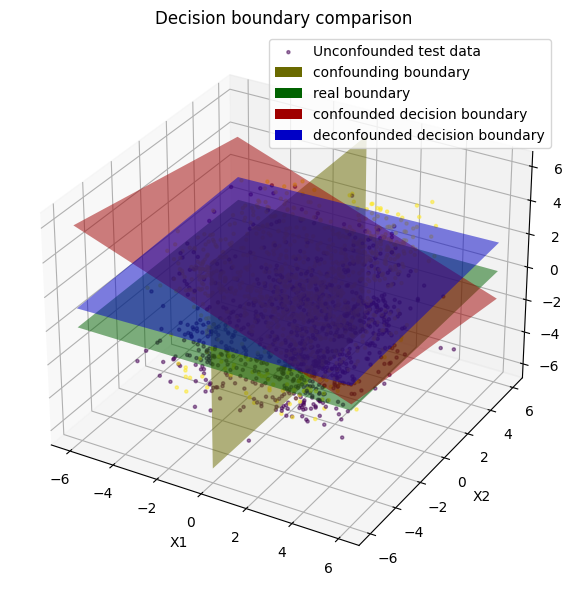

In [9]:
# Compare models' decision boundaries

# confounded svm boundary
xx1, xx2= np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
xx_conf = (-clf_conf.intercept_[0] - clf_conf.coef_[0][0] * xx1 - clf_conf.coef_[0][1] * xx2) / clf_conf.coef_[0][2]

# deconfounded svm boundary
xx1, xx2= np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
xx_cb = (-clf_cb.intercept_[0] - clf_cb.coef_[0][0] * xx1 - clf_cb.coef_[0][1] * xx2) / clf_cb.coef_[0][2]

#confounding boundary
conf_x2, conf_x3 = np.meshgrid(np.linspace(-6, 6, 20), np.linspace(-6, 6, 20))
conf_x1 = np.zeros((20,20))
# real boundary
real_x1, real_x2 = np.meshgrid(np.linspace(-6, 6, 20), np.linspace(-6, 6, 20))
real_x3 = np.full_like(real_x1, 0) 

plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test[:,0],X_test[:,1],X_test[:,2],c=Y_test, s = 5, alpha = 0.5)
surf1 = ax.plot_surface(conf_x1, conf_x2, conf_x3, alpha=0.5, rstride=100, cstride=100, color = "yellow", label = "confounding boundary")
surf2 = ax.plot_surface(real_x1, real_x2, real_x3, alpha=0.5, rstride=100, cstride=100, color = "green", label = "real boundary")
surf3 = ax.plot_surface(xx1, xx2, xx_conf, color='red', alpha=0.5, rstride=100, cstride=100, label = "confounded decision boundary")
surf4 = ax.plot_surface(xx1, xx2, xx_cb, color='blue', alpha=0.5, rstride=100, cstride=100, label = "confounded decision boundary")
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
surf1._facecolors2d=surf1._facecolors
surf1._edgecolors2d=surf1._edgecolors
surf2._facecolors2d=surf2._facecolors
surf2._edgecolors2d=surf2._edgecolors
surf3._facecolors2d=surf3._facecolors
surf3._edgecolors2d=surf3._edgecolors
surf4._facecolors2d=surf4._facecolors
surf4._edgecolors2d=surf4._edgecolors
ax.legend(["Unconfounded test data", "confounding boundary", "real boundary", "confounded decision boundary", "deconfounded decision boundary"])
plt.title('Decision boundary comparison')
plt.tight_layout()
plt.show()

#### Usage example: general_causal_bootstrapping_simu()

In [10]:
# Set simulated interventions and bootstrap the data
n_sample = 500
cb_data_1= workflows.general_causal_bootstrapping_simu(weight_func_lam = weight_func_lam, 
                                                       dist_map = dist_map, 
                                                       data = data, 
                                                       cause_intv_name_map = {"Y": "intv_Y"}, 
                                                       intv_dict = {"intv_Y": 1}, 
                                                       n_sample = n_sample, 
                                                       kernel = None)
cb_data_2= workflows.general_causal_bootstrapping_simu(weight_func_lam = weight_func_lam, 
                                                       dist_map = dist_map, 
                                                       data = data, 
                                                       cause_intv_name_map = {"Y": "intv_Y"}, 
                                                       intv_dict = {"intv_Y": 2}, 
                                                       n_sample = n_sample, 
                                                       kernel = None)
cb_data = {}
for key in cb_data_1:
    cb_data[key] = np.vstack((cb_data_1[key], cb_data_2[key]))

In [11]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=2)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=2)
clf_cb.fit(cb_data['X'], cb_data["intv_Y"].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv")
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.56      0.88      0.68       865
           2       0.84      0.46      0.60      1135

    accuracy                           0.65      2000
   macro avg       0.70      0.67      0.64      2000
weighted avg       0.72      0.65      0.63      2000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.73      0.79      0.76       865
           2       0.83      0.78      0.80      1135

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



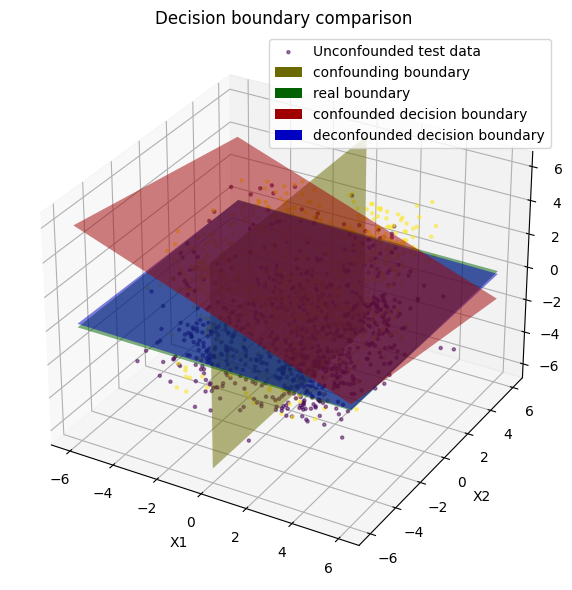

In [12]:
# Compare models' decision boundaries
# confounded svm boundary
xx1, xx2= np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
xx_conf = (-clf_conf.intercept_[0] - clf_conf.coef_[0][0] * xx1 - clf_conf.coef_[0][1] * xx2) / clf_conf.coef_[0][2]

# deconfounded svm boundary
xx1, xx2= np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
xx_cb = (-clf_cb.intercept_[0] - clf_cb.coef_[0][0] * xx1 - clf_cb.coef_[0][1] * xx2) / clf_cb.coef_[0][2]

plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test[:,0],X_test[:,1],X_test[:,2],c=Y_test, s = 5, alpha = 0.5)
surf1 = ax.plot_surface(conf_x1, conf_x2, conf_x3, alpha=0.5, rstride=100, cstride=100, color = "yellow", label = "confounding boundary")
surf2 = ax.plot_surface(real_x1, real_x2, real_x3, alpha=0.5, rstride=100, cstride=100, color = "green", label = "real boundary")
surf3 = ax.plot_surface(xx1, xx2, xx_conf, color='red', alpha=0.5, rstride=100, cstride=100, label = "confounded decision boundary")
surf4 = ax.plot_surface(xx1, xx2, xx_cb, color='blue', alpha=0.5, rstride=100, cstride=100, label = "confounded decision boundary")
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
surf1._facecolors2d=surf1._facecolors
surf1._edgecolors2d=surf1._edgecolors
surf2._facecolors2d=surf2._facecolors
surf2._edgecolors2d=surf2._edgecolors
surf3._facecolors2d=surf3._facecolors
surf3._edgecolors2d=surf3._edgecolors
surf4._facecolors2d=surf4._facecolors
surf4._edgecolors2d=surf4._edgecolors
ax.legend(["Unconfounded test data", "confounding boundary", "real boundary", "confounded decision boundary", "deconfounded decision boundary"])
plt.title('Decision boundary comparison')
plt.tight_layout()
plt.show()